### Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import PIL
import cv2

from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder

import datetime
import os

import warnings
warnings.filterwarnings("ignore")

Ładowanie i wstępne przetwarzanie obrazów

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/data_album_covers/images labeled/images labeled/disco/3_0.jpg")
type(img)

numpy.ndarray

In [ ]:
print(img.shape,img.dtype)

(400, 400, 3) uint8


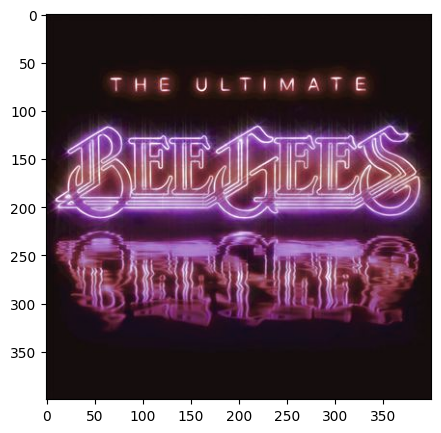

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.imshow(img)
plt.show()

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/data_album_covers/images labeled/images labeled'

In [ ]:
# załadowanie znioruzbioru danych - kod Kasi
categories = ['disco', 'electro', 'folk', 'rap', 'rock']

def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(f'/content/drive/MyDrive/Colab Notebooks/data_album_covers/images labeled/images labeled/{category}'): #path to the folders with data
            img = cv2.imread(f'/content/drive/MyDrive/Colab Notebooks/data_album_covers/images labeled/images labeled/{category}/{image_name}') #path to the folders
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_array = cv2.resize(img, (180,180))
            img_lst.append(img_array)
            labels.append(index)
    return img_lst, labels

img_lst, labels = load_images_and_labels(categories)

In [ ]:
len(img_lst)

9311

In [ ]:
len(labels)

9311


### Create a dataset - Keras method

Load and preprocess images

We will use 90% of the images for training and 10% for validation.
https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
data_dir='/content/drive/MyDrive/Colab Notebooks/data_album_covers/images labeled/images labeled' # path to the folders with data on my Google Drive

data= tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(180, 180)
  )



Found 9311 files belonging to 5 classes.


In [ ]:
for images, labels in data.take(-1):  # only take first element of dataset, if we want all elements, just insert -1
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

In [ ]:
 numpy_labels

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

data_dir='/content/drive/MyDrive/Colab Notebooks/data_album_covers/images labeled/images labeled' # path to the folders with data on my Google Drive


train_ds= tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9311 files belonging to 5 classes.
Using 8380 files for training.
Found 9311 files belonging to 5 classes.
Using 931 files for validation.


In [ ]:
class_names = train_ds.class_names # in this method labels are generated from the directory structure
print(class_names)
print(len(class_names))

['disco', 'electro', 'folk', 'rap', 'rock']
5


In [ ]:
 train_ds.file_paths[1]

'/content/drive/MyDrive/Colab Notebooks/data_album_covers/images labeled/images labeled/rap/0_1898.jpg'

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
image_batch.shape

TensorShape([32, 180, 180, 3])

In [ ]:
labels_batch.shape

TensorShape([32])

## Visualize the data

Here are the first 12 images from the training dataset:

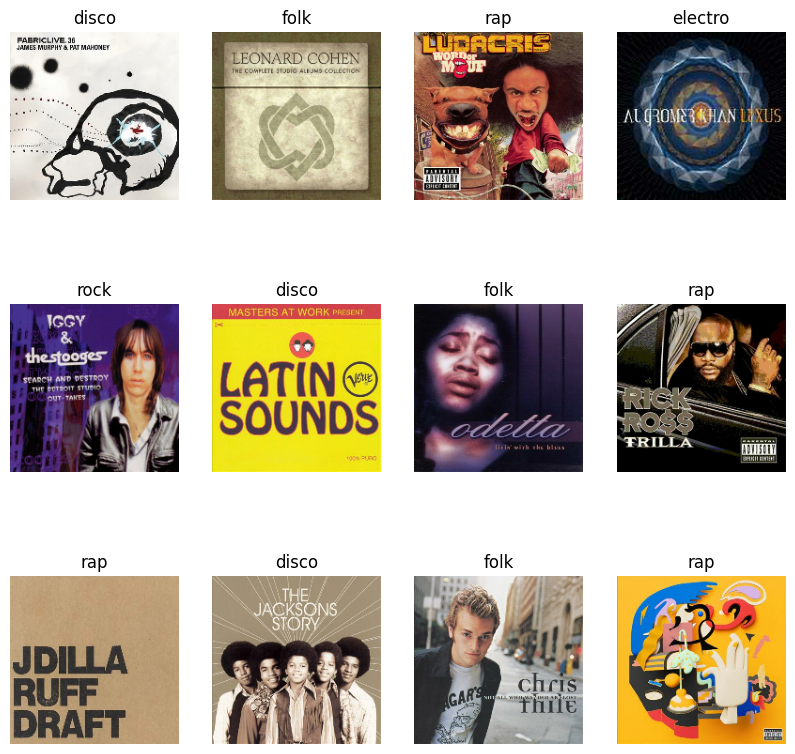

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Here are the first 12 images from the validation dataset:

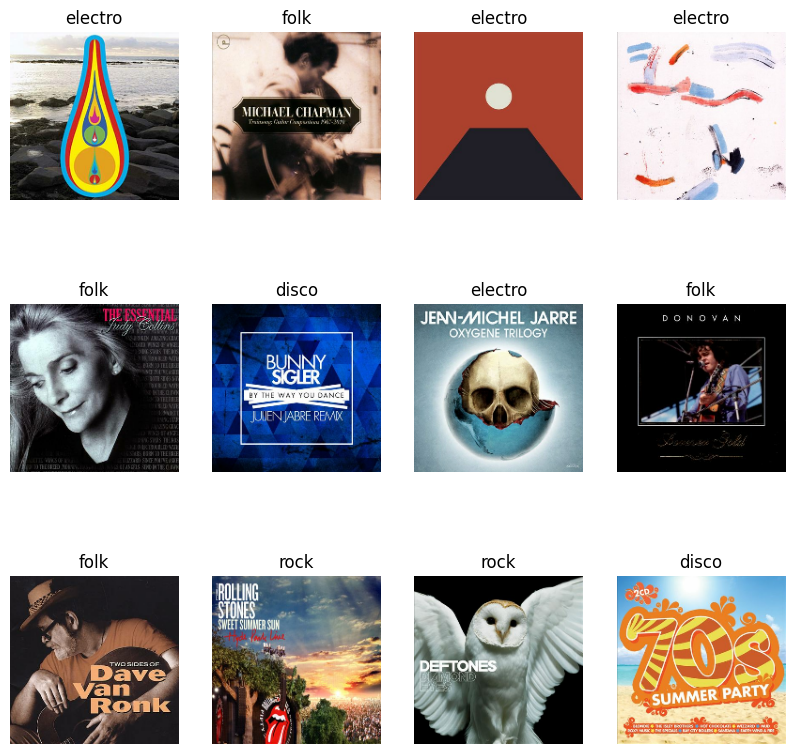

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [ ]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 3, 0, 3, 4, 4, 4, 3, 3, 2, 0, 2, 0, 2, 1, 2, 2, 3, 1, 1, 1, 2,
       0, 1, 1, 0, 0, 2, 0, 0, 3, 2], dtype=int32)>

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.


### Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; so we should seek to make our input values smaller.
We will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Configure the dataset for performance:
to use buffered prefetching, so you can yield data from disk without having I/O become blocking.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = len(class_names)

model_0 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(400, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])



In [ ]:
model_0.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history = model_0.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
262/262 [==============================] - 1078s 4s/step - loss: 1.6030 - accuracy: 0.2591 - val_loss: 1.5578 - val_accuracy: 0.3061
Epoch 2/10
262/262 [==============================] - 352s 1s/step - loss: 1.4777 - accuracy: 0.3561 - val_loss: 1.4726 - val_accuracy: 0.3523
Epoch 3/10
262/262 [==============================] - 337s 1s/step - loss: 1.2727 - accuracy: 0.4720 - val_loss: 1.5531 - val_accuracy: 0.3824
Epoch 4/10
262/262 [==============================] - 335s 1s/step - loss: 0.9261 - accuracy: 0.6382 - val_loss: 1.9504 - val_accuracy: 0.3813
Epoch 5/10
262/262 [==============================] - 342s 1s/step - loss: 0.5285 - accuracy: 0.8146 - val_loss: 2.4709 - val_accuracy: 0.4103
Epoch 6/10
262/262 [==============================] - 345s 1s/step - loss: 0.2838 - accuracy: 0.9107 - val_loss: 3.2432 - val_accuracy: 0.4039
Epoch 7/10
262/262 [==============================] - 368s 1s/step - loss: 0.1922 - accuracy: 0.9445 - val_loss: 3.4962 - val_accuracy: 0.411

In [ ]:
model_0.summary()

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
# wyświetlamy wykresy
ax[0][0].plot(history.history["loss"])
ax[0][1].plot(history.history["accuracy"])
ax[1][0].plot(history.history["val_loss"])
ax[1][1].plot(history.history["val_accuracy"])
#nazywamy zdjęcia
ax[0][0].set_title("train loss")
ax[0][1].set_title("train accuracy")
ax[1][0].set_title("validation loss")
ax[1][1].set_title("validation accuracy")
plt.show()

In [ ]:
plt.plot(history.history["loss"],label='Training Loss')
plt.plot(history.history["val_loss"],label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='center right')
plt.show()

plt.plot(history.history["accuracy"],label='Training Accuracy')
plt.plot(history.history["val_accuracy"],label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='center right')
plt.show()

### Predict on new data

In [ ]:
data_dir='/content/drive/MyDrive/Colab Notebooks/data_album_covers/images labeled/images labeled/' # path to the folders with data on my Google Drive

data_paths = [os.path.join(pth, f) for pth, dirs, files in os.walk(data_dir) for f in files]

len(data_paths)

9311

In [ ]:
data_paths[1]

'/content/drive/MyDrive/Colab Notebooks/data_album_covers/images labeled/images labeled/rap/0_1774.jpg'

In [ ]:
size = (180, 180)
image = tf.keras.utils.load_img(data_paths[1])
image = tf.keras.preprocessing.image.smart_resize(
    image , size, interpolation='bilinear'
)
input_arr = tf.keras.utils.img_to_array(image)
input_arr = np.array([input_arr]) # Convert single image to a batch.


In [ ]:
input_arr.shape

(1, 180, 180, 3)

In [ ]:
print(input_arr.shape,input_arr.dtype)

(1, 180, 180, 3) float32


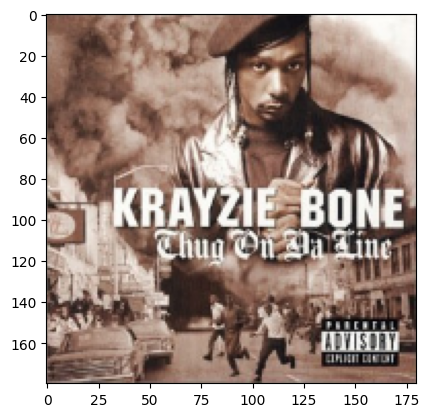

In [ ]:
plt.imshow(input_arr.astype(np.uint8))

In [ ]:
predictions = model_0.predict(input_arr)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 79ms/step
This image most likely belongs to rap with a 100.00 percent confidence.


In [ ]:
val_ds.file_paths[1]

NameError: ignored

### Another models

In [ ]:
num_classes = len(class_names)

model_2 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(400, activation='relu'),
  layers.Dense(num_classes)
])

model_2.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
ax[0][0].plot(history.history["loss"],label='Training Loss')
ax[0][0].plot(history.history["val_loss"],label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='center right')
plt.show()

ax[0][1].plot(history.history["accuracy"],label='Training Accuracy')
ax[0][1].plot(history.history["val_accuracy"],label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='center right')
plt.show()

### Data augmentation
When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add dropout to your model.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)

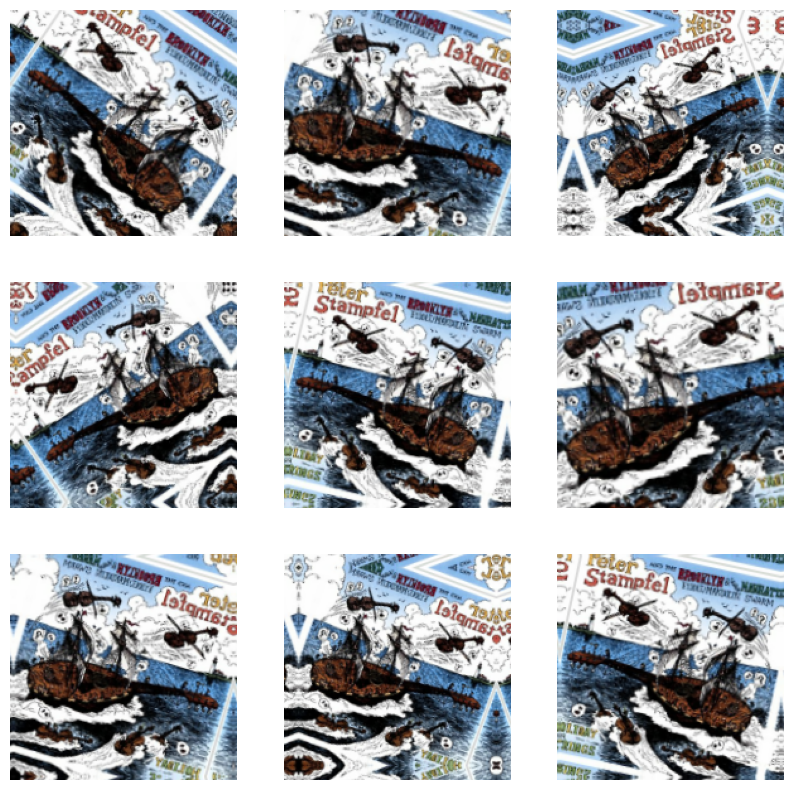

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout
to reduce overfitting

In [ ]:
model_1 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
log_dir = "logs\\" + "horses_humans\\" + "small_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# callback early stopping
# zatrzymanie treningu w momencie, kiedy val_loss nie spada przez n epok
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5
)

### Compile and train the model

In [ ]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[tensorboard_callback, es]
)

Epoch 1/10
262/262 [==============================] - 48s 156ms/step - loss: 1.6103 - accuracy: 0.2241 - val_loss: 1.5870 - val_accuracy: 0.2309
Epoch 2/10
262/262 [==============================] - 38s 140ms/step - loss: 1.5869 - accuracy: 0.2567 - val_loss: 1.6011 - val_accuracy: 0.2191
Epoch 3/10
262/262 [==============================] - 37s 141ms/step - loss: 1.5698 - accuracy: 0.2776 - val_loss: 1.5473 - val_accuracy: 0.3029
Epoch 4/10
262/262 [==============================] - 37s 139ms/step - loss: 1.5545 - accuracy: 0.2927 - val_loss: 1.5620 - val_accuracy: 0.2739
Epoch 5/10
262/262 [==============================] - 36s 136ms/step - loss: 1.5478 - accuracy: 0.3016 - val_loss: 1.5351 - val_accuracy: 0.3222
Epoch 6/10
262/262 [==============================] - 36s 136ms/step - loss: 1.5301 - accuracy: 0.3186 - val_loss: 1.5146 - val_accuracy: 0.3169
Epoch 7/10
262/262 [==============================] - 36s 135ms/step - loss: 1.5261 - accuracy: 0.3121 - val_loss: 1.5296 - val_ac

In [ ]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Visualize training results

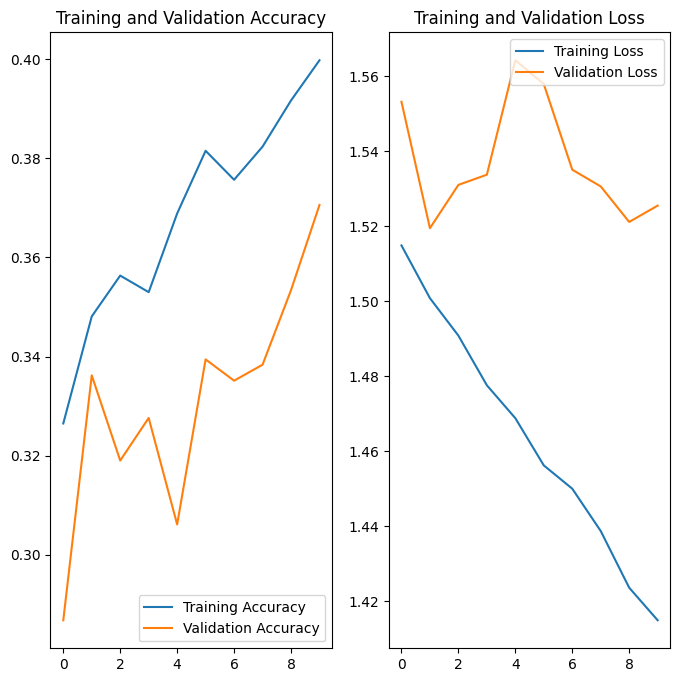

In [ ]:
epochs = 10

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

https://github.com/deepdrivepl/VMMRdb-simple-CNN/blob/master/train_v1.ipynb